<a href="https://colab.research.google.com/github/how-to-train-your-model/data-science-portfolio/blob/main/451_A5_Coding_Assignment_MDA_on_economic_factors_as_predictors_of_S%26P_500_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 5 Coding Assignment: 
MDA on economic factors as predictors of S&P 500 index


# Libraries

In [9]:
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# load libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import sweetviz as sv
from sklearn.impute import SimpleImputer
from datetime import datetime
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import log_loss,accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor




In [11]:
# Allows for muliple output in one cell window
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Allows for viewing the complete data in a single window 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [12]:
from google.colab import drive
drive.mount('/content/drive')
!ls -l "/content/drive/My Drive/Colab_Notebooks/MSDS-451/W5"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 7935
-rw------- 1 root root   59382 Feb 19 22:27 '451_A5_Coding Assignment: MDA on economic factors as predictors of S&P 500 index.ipynb'
-rw------- 1 root root  224921 Feb 19 18:11 '451_A5_Pant_Coding Assignment: MDA on economic factors as predictors of S&P 500 index.docx'
-rw------- 1 root root 7581770 Feb 19 20:20 'MSDS 451 Assignment_04_Chan-1.ipynb'
-rw------- 1 root root  244386 Feb 19 18:18  S_P_mnthly_returns_input-3.csv
-rw------- 1 root root   13711 Feb 19 18:18  S_P_mnthly_returns_output-3.csv


In [13]:
w5_files = "/content/drive/My Drive/Colab_Notebooks/MSDS-451/W5"

Data_In = pd.read_csv(w5_files+"/S_P_mnthly_returns_input-3.csv")
Ret_Out = pd.read_csv(w5_files+"/S_P_mnthly_returns_output-3.csv")

Data_In.head(2)
Ret_Out.head(2)
#Data_In.dtypes
Ret_Out.dtypes

,yyyymm,ntis,infl,ltr,corpr,svar,d/p,d/y,e/p,d/e,tms,dfy,dfr,b/m_FD,tbl_FD,lty_FD
0,1945-12-01,0.025525,0.005525,0.0194,0.0133,0.001538,-3.269684,-3.337063,-2.894991,-0.374693,0.0161,0.0049,-0.0061,-0.216009,-2.99635,-1.507835
1,1946-01-01,0.027969,0.000000,0.0025,0.0128,0.002645,-3.327012,-3.255014,-2.983423,-0.343589,0.0161,0.0047,0.0103,-0.264780,-2.99635,-1.486065


,yyyymm,ret
0,1945-12-01,1.0
1,1946-01-01,-1.0


yyyymm     object
ret       float64
dtype: object

In [14]:

# setting the date column as index for the dataset.
Data_In = Data_In.set_index('yyyymm')
Ret_Out = Ret_Out.set_index('yyyymm')

In [15]:
Data_In.head(2)
Ret_Out.head()

,ntis,infl,ltr,corpr,svar,d/p,d/y,e/p,d/e,tms,dfy,dfr,b/m_FD,tbl_FD,lty_FD
yyyymm,,,,,,,,,,,,,,,
1945-12-01,0.025525,0.005525,0.0194,0.0133,0.001538,-3.269684,-3.337063,-2.894991,-0.374693,0.0161,0.0049,-0.0061,-0.216009,-2.99635,-1.507835
1946-01-01,0.027969,0.000000,0.0025,0.0128,0.002645,-3.327012,-3.255014,-2.983423,-0.343589,0.0161,0.0047,0.0103,-0.264780,-2.99635,-1.486065


,ret
yyyymm,
1945-12-01,1.0
1946-01-01,-1.0
1946-02-01,1.0
1946-03-01,1.0
1946-04-01,1.0


# Question 1

Setting the random seed to 1, and using the same dataset as in the Module 4 assignment, compute the feature importance scores of each feature by applying the featImportance function (Snippet 8.8 in AFML) on the 10 cross validation sets within the train set defined there. Why can’t FS be applied to the train set as a whole? (For a hint, please read this.Links to an external site.) (2 pt) 

## Labels

In [16]:
# Defining Labels

#date	Index	D12	E12	b/m	tbl	ntis	
#infl	ltr	corpr	svar	csp	AAA_FD	BAA_FD	lty_FD

dfq1 = Data_In.copy()
dfq1 = Data_In.rename(columns={"yyyymm": "Date_YYYYMM"
  , "Index": "SP_500_Index"
  , "D12": "Twel_mon_mov_sums_of_divi"
  , "E12": "Twel_mon_mov_sums_of_earn"
  , "b/m": "Book_to_Market_Ratio"
  , "tbl": "Treasury_Bills"
  , "ntis": "Net_Equity_Expansion"
  , "ltr": "Long_Term_Rate_of_Returns"
  , "corpr": "Long_term_corporate_bond_return"
  , "svar": "Stock_Variance"
  , "csp": "Cross-Sectional_Premium"
  , "AAA_FD": "AAA_rated_bonds"
  , "BAA_BD": "BAA_rated_bonds"
  , "lty_FD": "Long_Term_Yield"}
  
  )

## EDA

In [17]:
dfq1.head(2)
df_EDA = dfq1.copy()

,Net_Equity_Expansion,infl,Long_Term_Rate_of_Returns,Long_term_corporate_bond_return,Stock_Variance,d/p,d/y,e/p,d/e,tms,dfy,dfr,b/m_FD,tbl_FD,Long_Term_Yield
yyyymm,,,,,,,,,,,,,,,
1945-12-01,0.025525,0.005525,0.0194,0.0133,0.001538,-3.269684,-3.337063,-2.894991,-0.374693,0.0161,0.0049,-0.0061,-0.216009,-2.99635,-1.507835
1946-01-01,0.027969,0.000000,0.0025,0.0128,0.002645,-3.327012,-3.255014,-2.983423,-0.343589,0.0161,0.0047,0.0103,-0.264780,-2.99635,-1.486065


In [18]:
#df_EDA['SP_500_Index'] = df_EDA['SP_500_Index'].str.replace(',', '').astype(float)


In [19]:
print("\n\n Duplicates",df_EDA.duplicated().sum())
#my_report = sv.analyze(df_EDA)
#my_report.show_html()



 Duplicates 0


In [20]:
print("\n\n Missing Values before dropping/Imputing \n",df_EDA.isna().sum())



 Missing Values before dropping/Imputing 
 Net_Equity_Expansion               0
infl                               0
Long_Term_Rate_of_Returns          0
Long_term_corporate_bond_return    0
Stock_Variance                     0
d/p                                0
d/y                                0
e/p                                0
d/e                                0
tms                                0
dfy                                0
dfr                                0
b/m_FD                             0
tbl_FD                             0
Long_Term_Yield                    0
dtype: int64


## 1.1 FI score
compute the feature importance scores of each feature by applying the featImportance function (Snippet 8.8 in AFML) on the 10 cross validation sets within the train set defined there. 

In [21]:
# preprring data fro q1

dfq1_In = Data_In.copy(deep = True)
dfq1_Out = Ret_Out.copy(deep = True)
#dfq1_In.dtypes

In [22]:
#dfq1_In['Index'] = dfq1_In['Index'].str.replace(',', '').astype(float)
dfq1_In.head(2)
dfq1_Out.head(2)

,ntis,infl,ltr,corpr,svar,d/p,d/y,e/p,d/e,tms,dfy,dfr,b/m_FD,tbl_FD,lty_FD
yyyymm,,,,,,,,,,,,,,,
1945-12-01,0.025525,0.005525,0.0194,0.0133,0.001538,-3.269684,-3.337063,-2.894991,-0.374693,0.0161,0.0049,-0.0061,-0.216009,-2.99635,-1.507835
1946-01-01,0.027969,0.000000,0.0025,0.0128,0.002645,-3.327012,-3.255014,-2.983423,-0.343589,0.0161,0.0047,0.0103,-0.264780,-2.99635,-1.486065


,ret
yyyymm,
1945-12-01,1.0
1946-01-01,-1.0


### Functions (from Scott)

In [23]:
#Derived from Advances in Financial Machine Learning, pp 116-117, Marcos Lopez de Prado
from sklearn.model_selection._split import KFold
import datetime as dt

def featImpMDA_classify(clf,X,y,cv,scoring='neg_log_loss'):
    # feat importance based on OOS score reduction
    if scoring not in ['neg_log_loss', 'accuracy']:
        raise Exception('wrong scoring method.')
    print('start MDA',dt.datetime.now())
    
    from sklearn.metrics import log_loss, accuracy_score
    cvGen=KFold(n_splits=cv)
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        print('   Split',i+1)
        X0,y0=X.iloc[train,:],y.iloc[train]
        X1,y1=X.iloc[test,:],y.iloc[test]
        fit=clf.fit(X=X0,y=y0)
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X1)
            scr0.loc[i]=-log_loss(y1,prob,labels=clf.classes_)
            
        else:
            pred=fit.predict(X1)
            scr0.loc[i]=accuracy_score(y1,pred)

        for j in X.columns:
            X1_=X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column
            if scoring=='neg_log_loss':
                prob=fit.predict_proba(X1_)
                scr1.loc[i,j]=-log_loss(y1,prob,labels=clf.classes_)
            else:
                pred=fit.predict(X1_)
                scr1.loc[i,j]=accuracy_score(y1,pred)
    imp=(0-scr1).add(scr0,axis=0)     #imp = scr1.add(scr0, axis = 0)
    imp =imp/(0-scr1)                 #imp=imp/-scr1
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    print('end MDA',dt.datetime.now())
    return imp

 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
    
# featImpMDA_classify(clf,X,y,cv,scoring='neg_log_loss')

def featImportance(trnsX,cont,n_estimators=1000,cv=10,max_samples=1,
                   numThreads=24,pctEmbargo=0,scoring='accuracy',
                   method='MDA',minWLeaf=0):
    # feature importance from a random forest
    
    n_jobs=(-1 if numThreads>1 else 1)
    # run 1 thread with ht_helper in dirac1
    #1) prepare classifier,cv. max_features=1, to prevent masking
    clf=DecisionTreeClassifier(criterion='entropy',max_features=1,
                                class_weight='balanced',
                               min_weight_fraction_leaf=minWLeaf)
    
    clf=BaggingClassifier(base_estimator=clf,n_estimators=n_estimators,
                          max_features=1,
                          max_samples=max_samples,
                          oob_score=True,n_jobs=n_jobs)
    
    fit=clf.fit(X=trnsX,y=cont)
    oob=fit.oob_score_
    imp,oos=featImpMDA_classify(clf,X=trnsX,y=cont,cv=cv,scoring=scoring)
        
    return imp,oob,oos


# From rfpimp: https://pypi.org/project/rfpimp/

def plot_importances(df_importances, save=None, xrot=0, tickstep=3,
                     label_fontsize=12,
                     figsize=None, scalefig=(1.0, 1.0), show=True, show_cutoff=False):
    """
    Given an array or data frame of importances, plot a horizontal bar chart
    showing the importance values.

    :param df_importances: A data frame with Feature, Importance columns
    :type df_importances: pd.DataFrame
    :param save: A filename identifying where to save the image.
    :param xrot: Degrees to rotate importance (X axis) labels
    :type xrot: int
    :param tickstep: How many ticks to skip in X axis
    :type tickstep: int
    :param label_fontsize:  The font size for the column names and x ticks
    :type label_fontsize:  int
    :param figsize: Specify width and height of image (width,height)
    :type figsize: 2-tuple of floats
    :param scalefig: Scale width and height of image (widthscale,heightscale)
    :type scalefig: 2-tuple of floats
    :param show: Execute plt.show() if true (default is True). Sometimes
                 we want to draw multiple things before calling plt.show()
    :type show: bool
    :return: None

    SAMPLE CODE
       rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = importances(rf, X_test, y_test)
    plot_importances(imp)
    """
    I = df_importances

    if figsize:
        fig = plt.figure(figsize=figsize)
    elif scalefig:
        fig = plt.figure()
        w, h = fig.get_size_inches()
        fig.set_size_inches(w * scalefig[0], h * scalefig[1], forward=True)
    else:
        fig = plt.figure()
    ax = plt.gca()
    labels = []
    for col in I.index:
        if isinstance(col, list):
            labels.append('\n'.join(col))
        else:
            labels.append(col)

    for tick in ax.get_xticklabels():
        tick.set_size(label_fontsize)
    for tick in ax.get_yticklabels():
        tick.set_size(label_fontsize)
    ax.barh(np.arange(len(I.index)), I.Importance, height=0.6, tick_label=labels)
    
    
    # rotate x-ticks
    if xrot is not None:
        plt.xticks(rotation=xrot)

    # xticks freq
    xticks = ax.get_xticks()
    nticks = len(xticks)
    new_ticks = xticks[np.arange(0, nticks, step=tickstep)]
    ax.set_xticks(new_ticks)
    
    if show_cutoff:
        # Plot the cutoff importance as vertical dotted line as per Figure 8.2 of AFML
        plt.axvline(1./df_importances.shape[0], linewidth = 1, color= 'r', linestyle = 'dotted')
        print('importance cutoff=', 1./df_importances.shape[0])
    if save:
        plt.savefig(save, bbox_inches="tight", pad_inches=0.03)
    if show:
        plt.show()

In [24]:
np.random.seed(1)
dfq1_In.head(2)
dfq1_Out.head(2)

,ntis,infl,ltr,corpr,svar,d/p,d/y,e/p,d/e,tms,dfy,dfr,b/m_FD,tbl_FD,lty_FD
yyyymm,,,,,,,,,,,,,,,
1945-12-01,0.025525,0.005525,0.0194,0.0133,0.001538,-3.269684,-3.337063,-2.894991,-0.374693,0.0161,0.0049,-0.0061,-0.216009,-2.99635,-1.507835
1946-01-01,0.027969,0.000000,0.0025,0.0128,0.002645,-3.327012,-3.255014,-2.983423,-0.343589,0.0161,0.0047,0.0103,-0.264780,-2.99635,-1.486065


,ret
yyyymm,
1945-12-01,1.0
1946-01-01,-1.0


In [25]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(dfq1_In, dfq1_Out, 
                                                    test_size=0.3)
#, random_state=1) # 70% training and 30% test


In [26]:
import warnings
warnings.simplefilter('ignore')
#np.random.seed(1)
clf = DecisionTreeClassifier(criterion = 'entropy', max_features = 1,
                                class_weight = 'balanced',
                               min_weight_fraction_leaf = 0)
    
clf = BaggingClassifier(base_estimator = clf, n_estimators = 1000,
                          max_features = 1,
                          max_samples = 1.,
                          oob_score = True, n_jobs = -1)

mda_imps = featImpMDA_classify(clf, X_train, y_train, cv = 10,
                               scoring = 'neg_log_loss')

#mda_imps = featImpMDA_classify(clf, X_train_in, Y_train_out, cv = 10,
 #                              scoring = 'neg_log_loss')


print(mda_imps.sort_values(by="mean",
                           ascending=False))

start MDA 2023-02-19 22:35:39.965494
   Split 1
   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2023-02-19 22:37:12.571663
            mean       std
ntis    0.007623  0.003249
tms     0.005154  0.001980
dfr     0.003164  0.003823
corpr   0.003045  0.001924
b/m_FD  0.003027  0.003488
d/e     0.002059  0.003519
infl    0.001886  0.003852
e/p     0.000615  0.003327
dfy     0.000119  0.002560
ltr    -0.000198  0.003940
tbl_FD -0.001530  0.003498
d/y    -0.001921  0.003832
d/p    -0.002065  0.004212
lty_FD -0.002198  0.003584
svar   -0.002449  0.004066


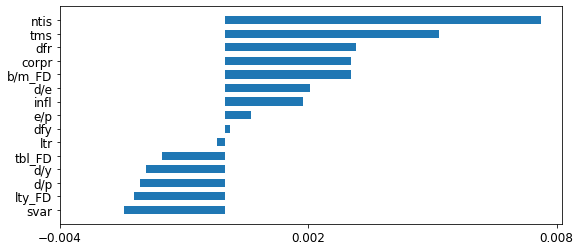

In [27]:
#With results, use something like this to plot the results:

import matplotlib.pyplot as plt

m_imps = mda_imps.reset_index().rename(index = int,
                                       columns = {"index":"Feature",
                                                  'mean':'Importance'},
                                        inplace = False).set_index('Feature')
m_imps = m_imps.sort_values(by = 'Importance')
plot_importances(m_imps, scalefig = (1.5, 1.0))


# Q2: FI score
If you obtain a different FI score for a feature in each cross validation subset, how is the overall FI score computed? (1 pt)

----

Response: If we obtain different feature importance (FI) scores for a feature in each cross-validation subset, you can compute an overall FI score by aggregating the subset scores by taking the average, mean, or median.

In the reference code provided, the feature importance after 10 cross-validation subsets is calculated as mean:   imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)


# Q3) 5 most important features
What are the 5 most important features? What are the features with above-average FI scores? (2 pt)


In [28]:
print(mda_imps.sort_values(by="mean", ascending=False))


            mean       std
ntis    0.007623  0.003249
tms     0.005154  0.001980
dfr     0.003164  0.003823
corpr   0.003045  0.001924
b/m_FD  0.003027  0.003488
d/e     0.002059  0.003519
infl    0.001886  0.003852
e/p     0.000615  0.003327
dfy     0.000119  0.002560
ltr    -0.000198  0.003940
tbl_FD -0.001530  0.003498
d/y    -0.001921  0.003832
d/p    -0.002065  0.004212
lty_FD -0.002198  0.003584
svar   -0.002449  0.004066


Dropping the negative importance variables before normalizing and choosing those with above-average FI scores.

In [29]:
# dropping columns with negative feature importance
mda_imps_q3 = m_imps.drop(['d/p', 'ltr', 'tbl_FD','d/y','lty_FD','svar'])

mda_imps_q3.sort_values(by = 'Importance', ascending = False)

,Importance,std
Feature,,
ntis,0.007623,0.003249
tms,0.005154,0.001980
dfr,0.003164,0.003823
corpr,0.003045,0.001924
b/m_FD,0.003027,0.003488
d/e,0.002059,0.003519
infl,0.001886,0.003852
e/p,0.000615,0.003327
dfy,0.000119,0.002560


In [30]:
#Normalize a column using min-max normalization
# mda_imps_q3['Importance']=(mda_imps_q3['Importance']-
#                            mda_imps_q3['Importance'].min()) /(mda_imps_q3['Importance'].max() -
#                                mda_imps_q3['Importance'].min())
# m_imps_q3 = mda_imps_q3.copy()

#https://stackoverflow.com/questions/67927245/normalize-column-sum-to-1

m_imps_q3 = mda_imps_q3/mda_imps_q3.sum()
m_imps_q3.sort_values(by = 'Importance', ascending = False)

,Importance,std
Feature,,
ntis,0.285602,0.117197
tms,0.193094,0.071426
dfr,0.118523,0.137912
corpr,0.114090,0.069390
b/m_FD,0.113404,0.125799
d/e,0.077132,0.126950
infl,0.070675,0.138960
e/p,0.023027,0.120021
dfy,0.004453,0.092344


importance cutoff= 0.1111111111111111


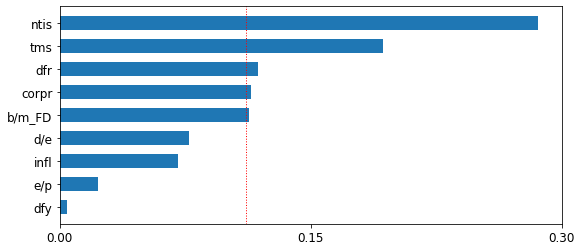

In [31]:
m_imps_q3 = m_imps_q3.reset_index().rename(index = int,
                                       columns = {"index":"Feature",
                                                  'mean':'Importance'},
                                        inplace = False).set_index('Feature')
m_imps_q3 = m_imps_q3.sort_values(by = 'Importance')
plot_importances(m_imps_q3,scalefig=(1.5,1.0), show_cutoff=True)

Response: Positive or negative values do not define the feature's importance. The features with max +ve ad -ve values are imp for the model

What are the 5 most important features?  

*   ntis
*   tms
*   dfr
*   lty_FD (negative)
*   svar (negative)

What are the features with above-average FI scores?

 - 'ntis'
 - tms
 - dfr
 - corpr
 - b/m_FD








# Q4: RF for A04
If you use only those above-average features as input, and retrain a RF as in the Module 4 assignment to predict the same labels, do any of the performance metrics improve? (2 pt) 


[Ref: A04_Code shared by Scott]

In [32]:
X_train.head(2)
X_train.shape
y_train.head(2)
y_train.shape

,ntis,infl,ltr,corpr,svar,d/p,d/y,e/p,d/e,tms,dfy,dfr,b/m_FD,tbl_FD,lty_FD
yyyymm,,,,,,,,,,,,,,,
1952-04-01,0.033231,0.003802,0.0171,-0.0004,0.000808,-2.791637,-2.814529,-2.282211,-0.509426,0.0097,0.0057,-0.0175,-0.054690,-2.237392,-1.387840
2018-09-01,-0.020856,0.001162,-0.0518,-0.0120,0.000230,-4.019533,-3.947604,-3.106745,-0.912788,0.0121,0.0090,0.0398,-0.579718,-2.010670,-1.178858


(621, 15)

,ret
yyyymm,
1952-04-01,1.0
2018-09-01,-1.0


(621, 1)

Considering only 4 variables those are above average cut-off 


*   ntis
*   d/e
*   b/m_FD
*   infl




In [33]:
q4_columns = ['ntis', 'tms', 'dfr', 'corpr', 'b/m_FD']
X_train4 = X_train[q4_columns]
y_train4 = y_train

X_test4 = X_test[q4_columns]
y_test4 = y_test

In [34]:
X_train4.head(2)
y_train4.shape
X_test4.head(2)
y_test4.shape

,ntis,tms,dfr,corpr,b/m_FD
yyyymm,,,,,
1952-04-01,0.033231,0.0097,-0.0175,-0.0004,-0.054690
2018-09-01,-0.020856,0.0121,0.0398,-0.0120,-0.579718


(621, 1)

,ntis,tms,dfr,corpr,b/m_FD
yyyymm,,,,,
1989-07-01,-0.028526,0.0013,-0.0060,0.0178,-0.397778
1972-02-01,0.033030,0.0282,0.0019,0.0107,-0.207258


(267, 1)

In [35]:
# Split dataset into training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X_processed_final, 
#                                                     y_final, 
#                                                     test_size=0.3) 


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train4,y_train4)

# Train Prediction

y_pred_train4=clf.predict(X_train4)

print('Training metrics for above average features')
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_train4, y_pred_train4))
print("F1 SCORE:",metrics.f1_score(y_train4,y_pred_train4))
print("AUC score:",metrics.roc_auc_score(y_train4,y_pred_train4))



# Test Pred

y_pred_test=clf.predict(X_test4)

print('\n\nTest metrics for above average features')
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test4, y_pred_test))
print("F1 SCORE:",metrics.f1_score(y_test4,y_pred_test))
print("AUC score:",metrics.roc_auc_score(y_test4,y_pred_test))

RandomForestClassifier()

Training metrics for above average features
Accuracy: 1.0
F1 SCORE: 1.0
AUC score: 1.0


Test metrics for above average features
Accuracy: 0.599250936329588
F1 SCORE: 0.6824925816023739
AUC score: 0.5712924462924464


Week 4 results:

 - Accuracy: 0.7865168539325843
 - F1 SCORE: 0.8626506024096385
 - AUC score: 0.6808099558653609

# Q5: Random seed to 2

Now set the random seed to 2, and recompute #3. Are they different? 

Response: As discussed in the video, we must expect chgange in the feature imp score for random seed = 2

*We set the seed = 1 in question # 1, hence bringing the code from 1 to check the FI score before dropping the variable and computing q#3*

In [36]:
np.random.seed(2)
dfq1_In.head(2)
dfq1_Out.head(2)

,ntis,infl,ltr,corpr,svar,d/p,d/y,e/p,d/e,tms,dfy,dfr,b/m_FD,tbl_FD,lty_FD
yyyymm,,,,,,,,,,,,,,,
1945-12-01,0.025525,0.005525,0.0194,0.0133,0.001538,-3.269684,-3.337063,-2.894991,-0.374693,0.0161,0.0049,-0.0061,-0.216009,-2.99635,-1.507835
1946-01-01,0.027969,0.000000,0.0025,0.0128,0.002645,-3.327012,-3.255014,-2.983423,-0.343589,0.0161,0.0047,0.0103,-0.264780,-2.99635,-1.486065


,ret
yyyymm,
1945-12-01,1.0
1946-01-01,-1.0


In [37]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(dfq1_In, dfq1_Out, 
                                                    test_size=0.3)

In [38]:
import warnings
warnings.simplefilter('ignore')
#np.random.seed(1)
clf = DecisionTreeClassifier(criterion = 'entropy', max_features = 1,
                                class_weight = 'balanced',
                               min_weight_fraction_leaf = 0)
    
clf = BaggingClassifier(base_estimator = clf, n_estimators = 1000,
                          max_features = 1,
                          max_samples = 1.,
                          oob_score = True, n_jobs = -1)

mda_imps = featImpMDA_classify(clf, X_train, y_train, cv = 10,
                               scoring = 'neg_log_loss')

#mda_imps = featImpMDA_classify(clf, X_train_in, Y_train_out, cv = 10,
 #                              scoring = 'neg_log_loss')


print(mda_imps.sort_values(by="mean",
                           ascending=False))

start MDA 2023-02-19 22:37:13.592249
   Split 1
   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2023-02-19 22:38:32.966929
            mean       std
d/y     0.009829  0.003670
d/e     0.003993  0.003127
dfr     0.003393  0.003845
lty_FD  0.001643  0.004422
ntis    0.001424  0.003078
tbl_FD  0.000875  0.003075
dfy     0.000536  0.002840
tms     0.000039  0.003523
ltr    -0.000204  0.004287
b/m_FD -0.000316  0.003928
e/p    -0.001134  0.003410
infl   -0.001892  0.003833
corpr  -0.003554  0.003352
svar   -0.005871  0.002699
d/p    -0.005957  0.003189


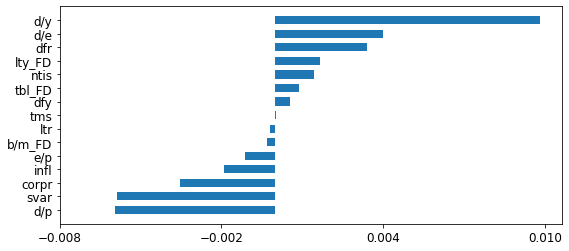

In [39]:
#With results, use something like this to plot the results:

import matplotlib.pyplot as plt

m_imps = mda_imps.reset_index().rename(index = int,
                                       columns = {"index":"Feature",
                                                  'mean':'Importance'},
                                        inplace = False).set_index('Feature')
m_imps = m_imps.sort_values(by = 'Importance')
plot_importances(m_imps, scalefig = (1.5, 1.0))


In [40]:
# dropping columns with negative feature importance
mda_imps_q5 = m_imps.drop(['d/p', 'corpr', 'b/m_FD','e/p','infl','svar', 'ltr'])

mda_imps_q5.sort_values(by = 'Importance', ascending = False)

,Importance,std
Feature,,
d/y,0.009829,0.003670
d/e,0.003993,0.003127
dfr,0.003393,0.003845
lty_FD,0.001643,0.004422
ntis,0.001424,0.003078
tbl_FD,0.000875,0.003075
dfy,0.000536,0.002840
tms,0.000039,0.003523


In [47]:
#https://stackoverflow.com/questions/67927245/normalize-column-sum-to-1

mda_imps_q5 = mda_imps_q5/mda_imps_q5.sum()
mda_imps_q5.sort_values(by = 'Importance', ascending = False)

,Importance,std
Feature,,
d/y,0.452317,0.133054
d/e,0.183740,0.113388
dfr,0.156121,0.139426
lty_FD,0.075602,0.160335
ntis,0.065514,0.111617
tbl_FD,0.040246,0.111488
dfy,0.024651,0.102969
tms,0.001808,0.127722


Dropping the negative importance variables before normalizing and choosing those with above-average FI scores.

importance cutoff= 0.125


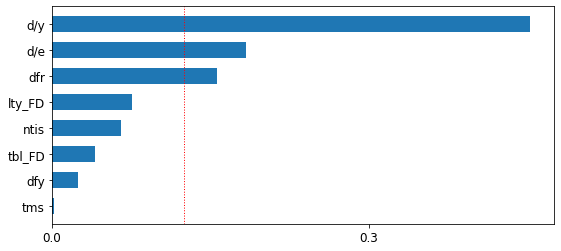

In [42]:
mda_imps_q5 = mda_imps_q5.reset_index().rename(index = int,
                                       columns = {"index":"Feature",
                                                  'mean':'Importance'},
                                        inplace = False).set_index('Feature')
mda_imps_q5 = mda_imps_q5.sort_values(by = 'Importance')
plot_importances(mda_imps_q5,scalefig=(1.5,1.0), show_cutoff=True)

Q5 - Response:

What are the 5 most important features?  

*   d/y
*   d/e
*   dfr
*   d/p (negative)
*   svar (negative)

What are the features with above-average FI scores?

*   d/y
*   d/e
*   dfr







# Q6: RF metrics with seed =2 compared to seed =1 
Retrain your RF model using the above-average features obtained in #5. Do any of the performance metrics improve over the Module 4 results? How do these metrics compare to those in #4 above? (2 pt)

In [43]:
X_train.head(2)
X_train.shape
y_train.head(2)
y_train.shape

,ntis,infl,ltr,corpr,svar,d/p,d/y,e/p,d/e,tms,dfy,dfr,b/m_FD,tbl_FD,lty_FD
yyyymm,,,,,,,,,,,,,,,
1978-12-01,0.014851,0.004451,-0.0130,-0.0133,0.001666,-2.942153,-2.981129,-2.053458,-0.888694,-0.001,0.0078,-0.0003,0.023301,-1.222199,-0.875129
1983-07-01,0.025380,0.004020,-0.0486,-0.0455,0.002293,-3.150868,-3.162123,-2.539518,-0.611349,0.029,0.0124,0.0031,-0.140918,-1.254207,-0.739813


(621, 15)

,ret
yyyymm,
1978-12-01,1.0
1983-07-01,1.0


(621, 1)

Considering only 4 variables those are above average cut-off 


*   ntis
*   d/e
*   b/m_FD
*   infl




In [44]:
q5_columns = ['d/y', 'd/e', 'dfr']
X_train5 = X_train[q5_columns]
y_train5 = y_train

X_test5 = X_test[q5_columns]
y_test5 = y_test

In [45]:
X_train5.head(2)
y_train5.shape
X_test5.head(2)
y_test5.shape

,d/y,d/e,dfr
yyyymm,,,
1978-12-01,-2.981129,-0.888694,-0.0003
1983-07-01,-3.162123,-0.611349,0.0031


(621, 1)

,d/y,d/e,dfr
yyyymm,,,
1992-07-01,-3.512687,-0.342069,-0.0090
1949-01-01,-2.737198,-0.896375,-0.0044


(267, 1)

In [46]:
# Split dataset into training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X_processed_final, 
#                                                     y_final, 
#                                                     test_size=0.3) 


#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train5,y_train5)

# Train Prediction

y_pred_train5=clf.predict(X_train5)

print('Training metrics for above average features')
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_train5, y_pred_train5))
print("F1 SCORE:",metrics.f1_score(y_train5,y_pred_train5))
print("AUC score:",metrics.roc_auc_score(y_train5,y_pred_train5))



# Test Pred

y_pred_test5=clf.predict(X_test5)

print('\n\nTest metrics for above average features')
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test5, y_pred_test5))
print("F1 SCORE:",metrics.f1_score(y_test5,y_pred_test5))
print("AUC score:",metrics.roc_auc_score(y_test5,y_pred_test5))

RandomForestClassifier()

Training metrics for above average features
Accuracy: 1.0
F1 SCORE: 1.0
AUC score: 1.0


Test metrics for above average features
Accuracy: 0.5617977528089888
F1 SCORE: 0.6309148264984228
AUC score: 0.5512632528761561


Q4: Test metrics for above average features
 - Accuracy: 0.5805243445692884
 - F1 SCORE: 0.6585365853658537
 - AUC score: 0.5578655578655578

Response: We didn't observe any change in the metrics as compared to # 4 with seed = 1